In [1]:
import pandas as pd
import math
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn import metrics
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense
from imblearn.over_sampling import SMOTE

%matplotlib inline

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Couldn't import dot_parser, loading of dot files will not be possible.


In [2]:
df = pd.read_excel('./Data/File1.xlsx')

## Feature Engineering

---

In my discussions with my SME there were two fields that were very important in helping to determine if someone will repay their loan.

- OOS Date: This is the out of statute date, which is the last date any litigation can be brought. The further away from this date the more likely you are to collect. I subtracted the date this portfolio was purchased from this date to get that number
- Cycle: This is the number of times the loan have been sent out for collection. Typically the fewer times collection attempts the more likely you are to collect.

In [3]:
# Date the protfolio was purchased
purchased_dt = pd.to_datetime('10/24/2008')

# Calculate the days until Out of Statute
df['OOS Days Left'] = df['OOS Date'] - purchased_dt
df['OOS Days Left int'] = 0

for i, _ in df.iterrows():
    days = df.iloc[i]['OOS Days Left'].days
    df.iloc[i,29] = days

In [4]:
# Dummy up the Cycle as this is an important feature
df = pd.get_dummies(df, columns = ['Cycle'])
df.columns

Index(['Account Number', 'PortID', 'Remaining Balance', 'interests Fees',
       'Date Opened', 'Charge Off Date', 'Last Pay Date', 'Last Pay Amount',
       'Last Activity Date', 'Interest Rate %', 'Issuer', 'Merchant',
       'FCFRA Date', 'OOS Date', 'Account Type', 'Last Name', 'First Name',
       'Middle Name', 'Address', 'City', 'State', 'Zip', 'County', 'SSN',
       'Home Phone', 'Employer Phone', 'Paid', 'OOS Days Left',
       'OOS Days Left int', 'Cycle_QUATERNARY', 'Cycle_SECONDARY',
       'Cycle_TERTIARY'],
      dtype='object')

## Write out the cleaned data

In [5]:
# Write out the new .csv file
df.to_csv("./Data/cleaned.csv", index=False)

## Creating the features for the model
In my discussions with my SME there are 6 features that will be the best in determining the likelihood of someone repaying their loan.

- Remaining Balance
- Interest Rate %
- interests Fees
- Last Pay Amount
- OOS Date: I'll use the number of day until that date which I calculated above
- Cycle: I'll use the dummies that I created above


In [6]:
num_cols = df.columns[[np.issubdtype(dt, np.number) for dt in df.dtypes]]

drop_cols = [key for key in dict(df.dtypes) 
                if dict(df.dtypes)[key] in ['datetime64[ns]', 'object']]

# Add others to drop list
drop_cols.extend(('Paid','Account Number','SSN','Home Phone',
                  'Employer Phone','OOS Days Left'))

In [7]:
num_cols

Index(['Account Number', 'Remaining Balance', 'interests Fees',
       'Last Pay Amount', 'Interest Rate %', 'SSN', 'Home Phone',
       'Employer Phone', 'Paid', 'OOS Days Left', 'OOS Days Left int',
       'Cycle_QUATERNARY', 'Cycle_SECONDARY', 'Cycle_TERTIARY'],
      dtype='object')

In [8]:
drop_cols

['PortID',
 'Date Opened',
 'Charge Off Date',
 'Last Pay Date',
 'Last Activity Date',
 'Issuer',
 'Merchant',
 'FCFRA Date',
 'OOS Date',
 'Account Type',
 'Last Name',
 'First Name',
 'Middle Name',
 'Address',
 'City',
 'State',
 'Zip',
 'County',
 'Paid',
 'Account Number',
 'SSN',
 'Home Phone',
 'Employer Phone',
 'OOS Days Left']

## Getting Ready To Model

In [9]:
y = df['Paid']
X = df.drop(columns = drop_cols)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.4, 
                                                    random_state=42, 
                                                    stratify=y)

ss = StandardScaler()
ss.fit(X_train)
X_train = ss.transform(X_train)
X_test = ss.transform(X_test)

### SMOTE (Synthetic Minority Over-sampling Technique)

In [11]:
print("Before OverSampling, counts of label '1': {}".format(sum(y_train==1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train==0)))

sm = SMOTE(k_neighbors=2,random_state=42)
X_train_res, y_train_res = sm.fit_sample(X_train, y_train.ravel())

print('After OverSampling, the shape of train_X: {}'.format(X_train_res.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape))

print("After OverSampling, counts of label '1': {}".format(sum(y_train_res==1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res==0)))

Before OverSampling, counts of label '1': 3
Before OverSampling, counts of label '0': 22 

After OverSampling, the shape of train_X: (44, 8)
After OverSampling, the shape of train_y: (44,) 

After OverSampling, counts of label '1': 22
After OverSampling, counts of label '0': 22


### Gridsearch Function

In [13]:
def build_model(model, model_params, X_train, y_train, X_test, y_test):
   
    model = model
    
    gs = GridSearchCV(model, param_grid=model_params, cv=5, n_jobs=3)
    gs.fit(X_train, y_train);

    print('Best parameters',gs.best_params_)

    # Model Accuracy, how often is the classifier correct
    accuracy = gs.best_score_
    print('Best Training Score: %.2f%%' % (accuracy * 100.0))

    accuracy = gs.score(X_test, y_test)
    print('Test Score: %.2f%%' % (accuracy * 100.0))

## Fitting and making predictions with the Logistic Regression model.

---

### Gridsearch to find best parameters

In [14]:
params = {
    'random_state':[42],
    'class_weight':['balanced',None]
}
build_model(LogisticRegression(), params, X_train_res, y_train_res.ravel(), X_test, y_test)

Best parameters {'class_weight': 'balanced', 'random_state': 42}
Best Training Score: 93.18%
Test Score: 82.35%


In [15]:
# Step 1: Instantiate our model.
logreg = LogisticRegression(class_weight=None,
                            random_state=42)

# Step 2: Fit our model.
logreg.fit(X_train_res, y_train_res.ravel())

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

### Confusion Matrix

#### Evaluation Metrics
Let's evaluate the model using model evaluation metrics such as accuracy, precision, and recall.

- Accuracy: Classification rate of 96% for the training and 82.35% for the test, which are considered great accuracy.

- Precision: Precision is about being precise, i.e., how accurate your model is. In other words, you can say, when a model makes a prediction, how often it is correct. In this  case, the training set was correct 100% of the time but the test set was 0% of the time.

- Recall: Sensitivity number is 66.67% for the training set but is 0% for the test set

In [20]:
y_train_pred = logreg.predict(X_train)

accuracy = metrics.accuracy_score(y_train, y_train_pred)
print('Accuracy for training set: %.2f%%' % (accuracy * 100.0))

precision = metrics.precision_score(y_train, y_train_pred)
print('Precision for training set: %.2f%%' % (precision * 100.0))

recall = metrics.recall_score(y_train, y_train_pred)
print('Recall for training set: %.2f%%' % (recall * 100.0))

Accuracy for training set: 96.00%
Precision for training set: 100.00%
Recall for training set: 66.67%


In [21]:
y_test_pred = logreg.predict(X_test)

accuracy = metrics.accuracy_score(y_test, y_test_pred)
print('Accuracy for test set: %.2f%%' % (accuracy * 100.0))

precision = metrics.precision_score(y_test, y_test_pred)
print('Precision for test set: %.2f%%' % (precision * 100.0))

recall = metrics.recall_score(y_test, y_test_pred)
print('Recall for test set: %.2f%%' % (recall * 100.0))

Accuracy for test set: 82.35%
Precision for test set: 0.00%
Recall for test set: 0.00%


#### ROC Curve
Receiver Operating Characteristic(ROC) curve is a plot of the true positive rate against the false positive rate. It shows the tradeoff between sensitivity and specificity.

- AUC score for the case is 0.4. AUC score 1 represents perfect classifier, and 0.4 represents a worthless classifier. This has been a consistent score. 

(0.0, 1.0)

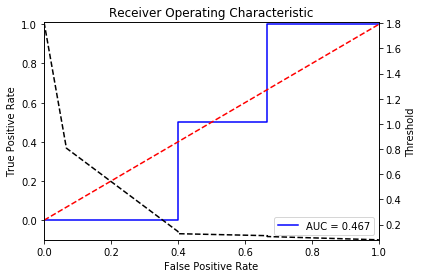

In [22]:
y_pred_proba = logreg.predict_proba(X_test)[::,1]


fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_proba)

roc_auc = metrics.auc(fpr,tpr)

# Plot ROC
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',label='AUC = %0.3f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.0])
plt.ylim([-0.1,1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

# create the axis of thresholds (scores)
ax2 = plt.gca().twinx()
ax2.plot(fpr, thresholds, markeredgecolor='k',linestyle='dashed', color='k')
ax2.set_ylabel('Threshold',color='k')
ax2.set_ylim([thresholds[-1],thresholds[0]])
ax2.set_xlim([fpr[0],fpr[-1]])

## Fitting and making predictions with DecisionTreeClassifier model.

---

### Gridsearch to find best parameters

In [23]:
params = {
    'criterion':['gini','entropy'],
    'random_state':[42],
    'class_weight':['balanced',None]
}
build_model(DecisionTreeClassifier(), params, 
            X_train_res, y_train_res.ravel(), X_test, y_test)

Best parameters {'class_weight': 'balanced', 'criterion': 'gini', 'random_state': 42}
Best Training Score: 79.55%
Test Score: 82.35%


### Build model with best parameters

In [27]:
dt = DecisionTreeClassifier(criterion='gini', 
                            class_weight='balanced',
                            random_state=42)

dt.fit(X_train_res, y_train_res.ravel())

DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best')

### Confusion Matrix

#### Evaluation Metrics
Let's evaluate the model using model evaluation metrics such as accuracy, precision, and recall.

- Accuracy: Classification rate of 100% for the training and 82.35% for the test, which are considered great accuracy.

- Precision: Precision is about being precise, i.e., how accurate your model is. In other words, you can say, when a model makes a prediction, how often it is correct. In this  case, the training set was correct 100% of the time but the test set was 0% of the time.

- Recall: Sensitivity number is 100% for the training set but is 0% for the test set

In [26]:
y_train_pred = dt.predict(X_train)

accuracy = metrics.accuracy_score(y_train, y_train_pred)
print('Accuracy for training set: %.2f%%' % (accuracy * 100.0))

precision = metrics.precision_score(y_train, y_train_pred)
print('Precision for training set: %.2f%%' % (precision * 100.0))

recall = metrics.recall_score(y_train, y_train_pred)
print('Recall for training set: %.2f%%' % (recall * 100.0))

Accuracy for training set: 100.00%
Precision for training set: 100.00%
Recall for training set: 100.00%


In [28]:
y_test_pred = dt.predict(X_test)

accuracy = metrics.accuracy_score(y_test, y_test_pred)
print('Accuracy for test set: %.2f%%' % (accuracy * 100.0))

precision = metrics.precision_score(y_test, y_test_pred)
print('Precision for test set: %.2f%%' % (precision * 100.0))

recall = metrics.recall_score(y_test, y_test_pred)
print('Recall for test set: %.2f%%' % (recall * 100.0))

Accuracy for test set: 82.35%
Precision for test set: 0.00%
Recall for test set: 0.00%


### What are the important features to this model

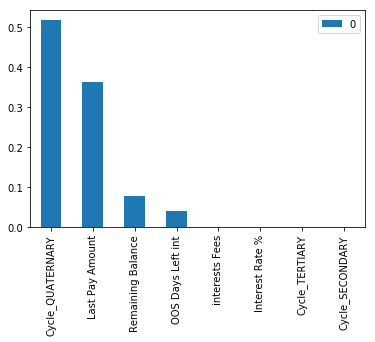

In [29]:
# decision trees can give us feature importances. the higher the number the more important
# the predictor was to deciding splits at nodes.
# "The importance of a feature is computed as the (normalized) total reduction of the 
# criterion brought by that feature."
#
feature_importances = dt.feature_importances_

importances = list(zip(dt.feature_importances_, X.columns))
importances.sort(reverse=True)

pd.DataFrame(importances, index=[x for (_,x) in importances]).plot(kind = 'bar')

### ROC Curve
Receiver Operating Characteristic(ROC) curve is a plot of the true positive rate against the false positive rate. It shows the tradeoff between sensitivity and specificity.

- AUC score for the case is 0.45. AUC score 1 represents perfect classifier, and 0.45 represents a worthless classifier. This has been a consistent score.

(0.0, 1.0)

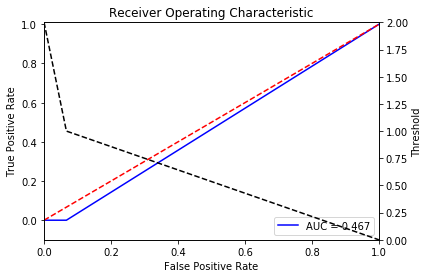

In [30]:
y_pred_proba = dt.predict_proba(X_test)[::,1]

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_proba)

roc_auc = metrics.auc(fpr,tpr)

# Plot ROC
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',label='AUC = %0.3f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.0])
plt.ylim([-0.1,1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

# create the axis of thresholds (scores)
ax2 = plt.gca().twinx()
ax2.plot(fpr, thresholds, markeredgecolor='k',linestyle='dashed', color='k')
ax2.set_ylabel('Threshold',color='k')
ax2.set_ylim([thresholds[-1],thresholds[0]])
ax2.set_xlim([fpr[0],fpr[-1]])

## Fitting and making predictions with RandomForestClassifier model.

-----

### Gridsearch to find best parameters

In [55]:
params = {
    'criterion':['gini','entropy'],
    'random_state':[42],
    'class_weight':['balanced',None],
    'n_estimators':[3,5]
}
build_model(RandomForestClassifier(), params, 
            X_train_res, y_train_res.ravel(), 
            X_test, y_test)

Best parameters {'class_weight': 'balanced', 'criterion': 'gini', 'n_estimators': 3, 'random_state': 42}
Best Training Score: 70.00%
Test Score: 92.31%


### Build model with best parameters

In [56]:
rf = RandomForestClassifier(criterion='gini',
                            class_weight='balanced',
                            n_estimators=5,
                            random_state=42)

rf.fit(X_train_res, y_train_res.ravel())

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=5, n_jobs=1, oob_score=False, random_state=42,
            verbose=0, warm_start=False)

### Confusion Matrix

#### Evaluation Metrics
Let's evaluate the model using model evaluation metrics such as accuracy, precision, and recall.

- Accuracy: Classification rate of 100% for the training and 88.24% for the test, which are considered great accuracy.

- Precision: Precision is about being precise, i.e., how accurate your model is. In other words, you can say, when a model makes a prediction, how often it is correct. In this  case, the training set was correct 100% of the time but the test set was 0% of the time.

- Recall: Sensitivity number is 100% for the training set but is 0% for the test set

In [35]:
y_train_pred = rf.predict(X_train)

accuracy = metrics.accuracy_score(y_train, y_train_pred)
print('Accuracy for training set: %.2f%%' % (accuracy * 100.0))

precision = metrics.precision_score(y_train, y_train_pred)
print('Precision for training set: %.2f%%' % (precision * 100.0))

recall = metrics.recall_score(y_train, y_train_pred)
print('Recall for training set: %.2f%%' % (recall * 100.0))

Accuracy for training set: 100.00%
Precision for training set: 100.00%
Recall for training set: 100.00%


In [36]:
y_test_pred = rf.predict(X_test)

accuracy = metrics.accuracy_score(y_test, y_test_pred)
print('Accuracy for test set: %.2f%%' % (accuracy * 100.0))

precision = metrics.precision_score(y_test, y_test_pred)
print('Precision for test set: %.2f%%' % (precision * 100.0))

recall = metrics.recall_score(y_test, y_test_pred)
print('Recall for test set: %.2f%%' % (recall * 100.0))

Accuracy for test set: 88.24%
Precision for test set: 0.00%
Recall for test set: 0.00%


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


### What are the important features to this model

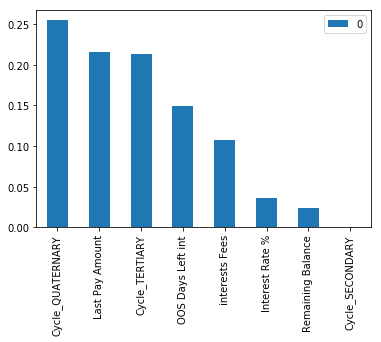

In [37]:
# decision trees can give us feature importances. the higher the number the more important
# the predictor was to deciding splits at nodes.
# "The importance of a feature is computed as the (normalized) total reduction of the 
# criterion brought by that feature."
#
feature_importances = rf.feature_importances_

importances = list(zip(rf.feature_importances_, X.columns))
importances.sort(reverse=True)

pd.DataFrame(importances, index=[x for (_,x) in importances]).plot(kind = 'bar')

### ROC Curve
Receiver Operating Characteristic(ROC) curve is a plot of the true positive rate against the false positive rate. It shows the tradeoff between sensitivity and specificity.

- AUC score for the case is 0.45. AUC score 1 represents perfect classifier, and 0.45 represents a worthless classifier. This has been a consistent score.

(0.0, 1.0)

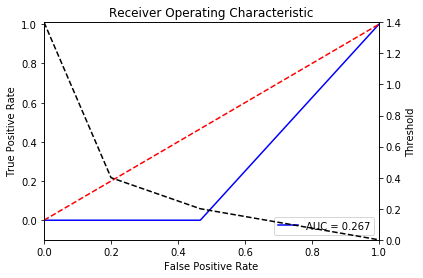

In [38]:
y_pred_proba = rf.predict_proba(X_test)[::,1]


fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_proba)

roc_auc = metrics.auc(fpr,tpr)

# Plot ROC
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',label='AUC = %0.3f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.0])
plt.ylim([-0.1,1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

# create the axis of thresholds (scores)
ax2 = plt.gca().twinx()
ax2.plot(fpr, thresholds, markeredgecolor='k',linestyle='dashed', color='k')
ax2.set_ylabel('Threshold',color='k')
ax2.set_ylim([thresholds[-1],thresholds[0]])
ax2.set_xlim([fpr[0],fpr[-1]])

## Fitting and making predictions with Gradient Boost model.

---

### Gridsearch to find best parameters

In [40]:
params = {
    'n_estimators':[80,90,100],
    'learning_rate':[.1,.11,.15],
    'max_depth':[1,2,3],
    'random_state':[42]
}
build_model(GradientBoostingClassifier(), params, 
            X_train_res, y_train_res.ravel(), X_test, y_test)

Best parameters {'learning_rate': 0.1, 'max_depth': 1, 'n_estimators': 80, 'random_state': 42}
Best Training Score: 90.91%
Test Score: 88.24%


### Build model with best parameters

In [41]:
grad_boost = GradientBoostingClassifier(learning_rate=0.11,
                                        max_depth=1,
                                        n_estimators=80,
                                        random_state=42)

grad_boost.fit(X_train_res, y_train_res.ravel())

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.11, loss='deviance', max_depth=1,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=80,
              presort='auto', random_state=42, subsample=1.0, verbose=0,
              warm_start=False)

### Confusion Matrix

#### Evaluation Metrics
Let's evaluate the model using model evaluation metrics such as accuracy, precision, and recall.

- Accuracy: Classification rate of 96% for the training and 88.24% for the test, which are considered great accuracy.

- Precision: Precision is about being precise, i.e., how accurate your model is. In other words, you can say, when a model makes a prediction, how often it is correct. In this  case, the training set was correct 100% of the time but the test set was 0% of the time.

- Recall: Sensitivity number is 66.67% for the training set but is 0% for the test set

In [44]:
y_train_pred = grad_boost.predict(X_train)

accuracy = metrics.accuracy_score(y_train, y_train_pred)
print('Accuracy for training set: %.2f%%' % (accuracy * 100.0))

precision = metrics.precision_score(y_train, y_train_pred)
print('Precision for training set: %.2f%%' % (precision * 100.0))

recall = metrics.recall_score(y_train, y_train_pred)
print('Recall for training set: %.2f%%' % (recall * 100.0))

Accuracy for training set: 96.00%
Precision for training set: 100.00%
Recall for training set: 66.67%


In [45]:
y_test_pred = grad_boost.predict(X_test)

accuracy = metrics.accuracy_score(y_test, y_test_pred)
print('Accuracy for test set: %.2f%%' % (accuracy * 100.0))

precision = metrics.precision_score(y_test, y_test_pred)
print('Precision for test set: %.2f%%' % (precision * 100.0))

recall = metrics.recall_score(y_test, y_test_pred)
print('Recall for test set: %.2f%%' % (recall * 100.0))

Accuracy for test set: 88.24%
Precision for test set: 0.00%
Recall for test set: 0.00%


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


### What are the important features to this model

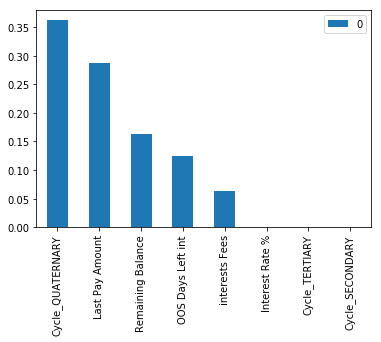

In [46]:
# decision trees can give us feature importances. the higher the number the more important
# the predictor was to deciding splits at nodes.
# "The importance of a feature is computed as the (normalized) total reduction of the 
# criterion brought by that feature."
#
feature_importances = grad_boost.feature_importances_

importances = list(zip(grad_boost.feature_importances_, X.columns))
importances.sort(reverse=True)

pd.DataFrame(importances, index=[x for (_,x) in importances]).plot(kind = 'bar')

### ROC Curve
Receiver Operating Characteristic(ROC) curve is a plot of the true positive rate against the false positive rate. It shows the tradeoff between sensitivity and specificity.

- AUC score for the case is 0.45. AUC score 1 represents perfect classifier, and 0.45 represents a worthless classifier. This has been a consistent score.

(0.0, 1.0)

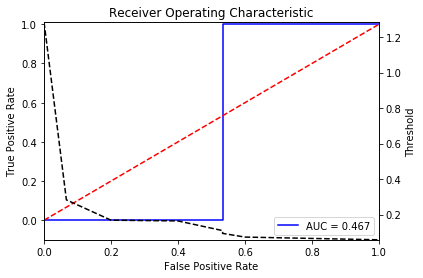

In [47]:
y_pred_proba = grad_boost.predict_proba(X_test)[::,1]


fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_proba)

roc_auc = metrics.auc(fpr,tpr)

# Plot ROC
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',label='AUC = %0.3f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.0])
plt.ylim([-0.1,1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

# create the axis of thresholds (scores)
ax2 = plt.gca().twinx()
ax2.plot(fpr, thresholds, markeredgecolor='k',linestyle='dashed', color='k')
ax2.set_ylabel('Threshold',color='k')
ax2.set_ylim([thresholds[-1],thresholds[0]])
ax2.set_xlim([fpr[0],fpr[-1]])

## Fitting and making predictions with KNeighborsClassifier model.

---

#### Instantiate KNN

For the `KNeighborsClassifier`, there a few important parameters to keep in mind:

1. `n_neighbors`: this is the "K" in KNN. The best K will change from problem to problem, but the default is 5.
2. `weights`: The neighbors can all have an equal vote (`uniform`), or the closer points can have a higher weighted vote (`distance`).
3. `p`: The distance metric. The default is Euclidean distance (2). Changing it to 1 is setting the distance to Manhattan.

In the cell below, instantiate a `knn` model using the default parameters.

In [112]:
# Because these are dummy vaiables scaling is not required
features = ['Cycle_QUATERNARY', 
            'Cycle_SECONDARY', 
            'Cycle_TERTIARY', 
           ]

X_knn = df[features]
y_knn = df['Paid']

# Split dataset into training set and test set 70% training and 30% test
X_train, X_test, y_train, y_test = train_test_split(X_knn, y_knn, test_size=0.3) 

### SMOTE (Synthetic Minority Over-sampling Technique)

In [113]:
print("Before OverSampling, counts of label '1': {}".format(sum(y_train==1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train==0)))

sm = SMOTE(k_neighbors=1,random_state=42)
X_train_res, y_train_res = sm.fit_sample(X_train, y_train.ravel())

print('After OverSampling, the shape of train_X: {}'.format(X_train_res.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape))

print("After OverSampling, counts of label '1': {}".format(sum(y_train_res==1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res==0)))

Before OverSampling, counts of label '1': 4
Before OverSampling, counts of label '0': 25 

After OverSampling, the shape of train_X: (50, 3)
After OverSampling, the shape of train_y: (50,) 

After OverSampling, counts of label '1': 25
After OverSampling, counts of label '0': 25


### Gridsearch to find best parameters

In [114]:
params = {
    'n_neighbors':[3,5,7],
    'algorithm':['auto']
}
build_model(KNeighborsClassifier(), params, 
            X_train_res, y_train_res.ravel(), X_test, y_test)

Best parameters {'algorithm': 'auto', 'n_neighbors': 3}
Best Training Score: 54.00%
Test Score: 92.31%


### Build model with best parameters

In [115]:
knn = KNeighborsClassifier(algorithm='auto',
                           n_neighbors=8)
knn.fit(X_train_res, y_train_res.ravel())

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=8, p=2,
           weights='uniform')

### Confusion Matrix

#### Evaluation Metrics
Let's evaluate the model using model evaluation metrics such as accuracy, precision, and recall.

- Accuracy: Classification rate of 86.12% for the training and 92.31% for the test, which are considered great accuracy.

- Precision: Precision is about being precise, i.e., how accurate your model is. In other words, you can say, when a model makes a prediction, how often it is correct. In this  case, the training set was correct 0% of the time but the test set was 0% of the time.

- Recall: Sensitivity number is 0% for the training set but is 0% for the test set

In [116]:
y_train_pred = knn.predict(X_train)

accuracy = metrics.accuracy_score(y_train, y_train_pred)
print('Accuracy for training set: %.2f%%' % (accuracy * 100.0))

precision = metrics.precision_score(y_train, y_train_pred)
print('Precision for training set: %.2f%%' % (precision * 100.0))

recall = metrics.recall_score(y_train, y_train_pred)
print('Recall for training set: %.2f%%' % (recall * 100.0))

Accuracy for training set: 86.21%
Precision for training set: 0.00%
Recall for training set: 0.00%


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [117]:
y_test_pred = knn.predict(X_test)

accuracy = metrics.accuracy_score(y_test, y_test_pred)
print('Accuracy for test set: %.2f%%' % (accuracy * 100.0))

precision = metrics.precision_score(y_test, y_test_pred)
print('Precision for test set: %.2f%%' % (precision * 100.0))

recall = metrics.recall_score(y_test, y_test_pred)
print('Recall for test set: %.2f%%' % (recall * 100.0))

Accuracy for test set: 92.31%
Precision for test set: 0.00%
Recall for test set: 0.00%


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


### ROC Curve
Receiver Operating Characteristic(ROC) curve is a plot of the true positive rate against the false positive rate. It shows the tradeoff between sensitivity and specificity.

- AUC score for the case is 0.45. AUC score 1 represents perfect classifier, and 0.45 represents a worthless classifier. This has been a consistent score.

(0.0, 1.0)

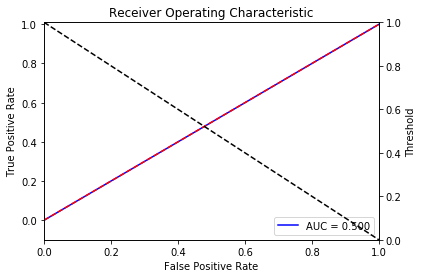

In [118]:
y_pred_proba = knn.predict_proba(X_test)[::,1]


fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_proba)

roc_auc = metrics.auc(fpr,tpr)

# Plot ROC
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',label='AUC = %0.3f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.0])
plt.ylim([-0.1,1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

# create the axis of thresholds (scores)
ax2 = plt.gca().twinx()
ax2.plot(fpr, thresholds, markeredgecolor='k',linestyle='dashed', color='k')
ax2.set_ylabel('Threshold',color='k')
ax2.set_ylim([thresholds[-1],thresholds[0]])
ax2.set_xlim([fpr[0],fpr[-1]])